# AIF Example Workflow

This notebook demonstrates what the **Automated Interpretation Framework (AIF)** does: it evaluates multiple phase interpretations for an XRD pattern by combining four key metrics, then displays the results and plots.

**Run this notebook from the project root** (e.g. `jupyter notebook notebooks/AIF_example_workflow.ipynb` from the repo root).

## 1. Setup and load data

In [35]:
import sys
import json
from pathlib import Path

import pandas as pd

# Add src to path
ROOT = Path.cwd()
if (ROOT / "notebooks").exists():
    ROOT = ROOT  # cwd is project root
else:
    ROOT = ROOT.parent  # cwd is notebooks/
SRC = ROOT / "src"
sys.path.insert(0, str(SRC))

# Output directory for plots (inside notebooks for easy display)
OUTPUT_DIR = ROOT / "notebooks" / "example_output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load interpretations and synthesis data
INTERP_PATH = ROOT / "data" / "xrd_data" / "interpretations" / "interpretations.json"
CSV_PATH = ROOT / "data" / "xrd_data" / "synthesis_data.csv"

with open(INTERP_PATH) as f:
    all_interpretations = json.load(f)

df = pd.read_csv(CSV_PATH)


SAMPLE_KEY = "TRI_197"
interpretations = all_interpretations[SAMPLE_KEY]
filtered_df = df[df["Name"].str.contains(rf'^{SAMPLE_KEY}$', na=False)]
if filtered_df.empty:
    filtered_df = df[df["Name"].str.contains(rf'^{SAMPLE_KEY.replace("_", "-")}$', na=False)]
target = filtered_df["Target"].iloc[0]
precursors = filtered_df["Precursors"].iloc[0]
temp = filtered_df["Temperature (C)"].iloc[0]
dwell = filtered_df["Dwell Duration (h)"].iloc[0]
furnace = filtered_df["Furnace"].iloc[0]

print(f"Sample: {SAMPLE_KEY}")
print(f"Target phase: {target}")
print(f"\nSynthesis conditions:")
print(f"  Precursors: {precursors}")
print(f"  Temperature: {temp}°C")
print(f"  Dwell time: {dwell} hours")
print(f"  Furnace: {furnace}")
print(f"\nInterpretations: {list(interpretations.keys())}")

Sample: TRI_197
Target phase: CaVO2

Synthesis conditions:
  Precursors: ['CaCO3', 'V2O5']
  Temperature: 600°C
  Dwell time: 12.0 hours
  Furnace: TF-Ar+H2

Interpretations: ['I_1', 'I_2', 'I_3', 'I_4']


## 2. The four metrics

Each interpretation is scored using four metrics that feed into the posterior probability:

### 2.1 Composition balance score

Measures how well the combined phase composition matches the target composition from synthesis. A score of 1 means a perfect match; lower scores indicate missing elements, extra elements, or stoichiometry mismatches.

In [36]:
from IPython.display import display, HTML

print("=" * 70)
print("COMPOSITION BALANCE SCORE (0–1, higher = better match)")
print("=" * 70)
for key, data in interpretations.items():
    bal = data.get("balance_score", 0)
    val = bal if bal is not None else 0
    phases = ", ".join(data.get("phases", []))
    print(f"\n{key}: {val:.3f}")
    print(f"  Phases: {phases}")

COMPOSITION BALANCE SCORE (0–1, higher = better match)

I_1: 0.998
  Phases: CaC2_2, CaV2O5_59

I_2: 0.992
  Phases: CaV2O5_59, Ca5V3O13_176

I_3: 0.375
  Phases: CaC2_2

I_4: 0.375
  Phases: CaCO3_2


### 2.2 LLM interpretation likelihood and explanation

The LLM evaluates whether the phase combination is plausible under the synthesis conditions (temperature, atmosphere, precursors). It returns a likelihood (0–1) and a natural-language explanation.

In [37]:
print("=" * 70)
print("LLM INTERPRETATION LIKELIHOOD (0–1) & EXPLANATION")
print("=" * 70)
for key, data in interpretations.items():
    llm = data.get("LLM_interpretation_likelihood", 0)
    val = llm if llm is not None else 0
    expl = data.get("LLM_interpretation_explanation", "(no explanation)")
    print(f"\n{key}: {val:.3f}")
    print(f"  Explanation: {expl[:1000]}..." if len(str(expl)) > 1000 else f"  Explanation: {expl}")

LLM INTERPRETATION LIKELIHOOD (0–1) & EXPLANATION

I_1: 0.400
  Explanation: The presence of CaC2 is highly unlikely, significantly reducing the overall plausibility of this interpretation. CaV2O5 is plausible, but the interpretation is weakened by the inclusion of an improbable carbide phase.

I_2: 0.600
  Explanation: This interpretation is more plausible than I_1 due to the absence of highly unlikely phases. Both phases are plausible under the given conditions, though the reducing atmosphere is not ideal for their stability.

I_3: 0.100
  Explanation: The interpretation is highly implausible due to the exclusive presence of CaC2, which is unlikely to form under the given synthesis conditions.

I_4: 0.300
  Explanation: The presence of only CaCO3 suggests an incomplete reaction, which is plausible but not consistent with the target phase formation. The interpretation lacks the expected vanadium-containing phases.


### 2.3 RWP (weighted profile R-factor)

Measures how well the calculated XRD pattern fits the observed pattern. **Lower RWP is better** (typical good fits are &lt; 20). The framework normalizes RWP to a 0–1 scale for combination with other metrics.

In [38]:
print("=" * 70)
print("RWP (lower = better fit) & NORMALIZED RWP (0–1, higher = better)")
print("=" * 70)
for key, data in interpretations.items():
    rwp = data.get("rwp", "—")
    norm = data.get("normalized_rwp")
    val = norm if norm is not None else "—"
    norm_str = f"{val:.3f}" if val != "—" else "—"
    print(f"\n{key}: RWP = {rwp}, normalized = {norm_str}")

RWP (lower = better fit) & NORMALIZED RWP (0–1, higher = better)

I_1: RWP = 16.16, normalized = 0.731

I_2: RWP = 16.27, normalized = 0.729

I_3: RWP = 18.05, normalized = 0.699

I_4: RWP = 17.39, normalized = 0.710


### 2.4 Score (peak matching)

Measures how well the calculated peaks match the observed peaks (peak positions and intensities). **Higher score is better.** The raw score is normalized via a sigmoid for combination with other metrics.

In [39]:
print("=" * 60)
print("SCORE (peak matching, higher = better) & NORMALIZED SCORE (0–1)")
print("=" * 60)
for key, data in interpretations.items():
    score = data.get("score", "—")
    norm = data.get("normalized_score")
    norm_pct = f"{norm*100:.1f}%" if norm is not None else "—"
    print(f"\n{key}: score = {score}, normalized = {norm_pct}")

SCORE (peak matching, higher = better) & NORMALIZED SCORE (0–1)

I_1: score = 0.06559202026598322, normalized = 37.2%

I_2: score = 0.1507639717187302, normalized = 43.8%

I_3: score = 0.030591620794814495, normalized = 34.6%

I_4: score = 0.202231659184716, normalized = 48.0%


## 3. Combined posterior probability

The framework combines these metrics into a **prior** (from composition balance + LLM) and **fit quality** (from RWP + score), then computes the **posterior probability** for each interpretation.

In [40]:
print("=" * 70)
print("POSTERIOR PROBABILITIES (sum to 1)")
print("=" * 70)
for key, data in interpretations.items():
    post = data.get("posterior_probability") 
    val = post if post is not None else 0
    print(f"{key}: {val:.3f}")

POSTERIOR PROBABILITIES (sum to 1)
I_1: 0.339
I_2: 0.388
I_3: 0.112
I_4: 0.161


## 4. Generate and display plots

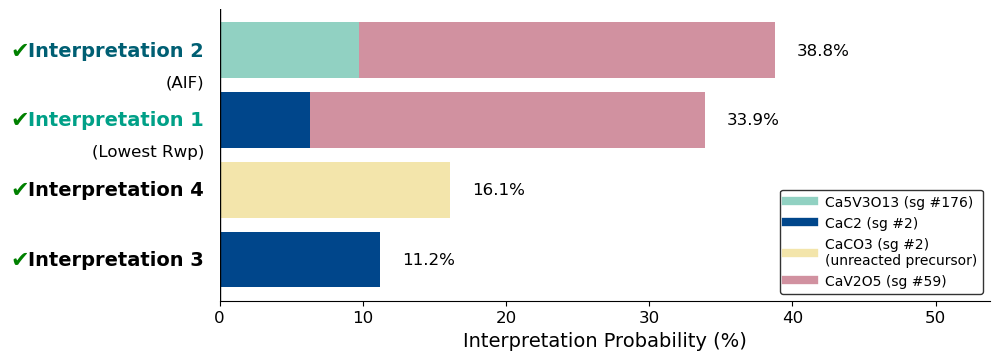

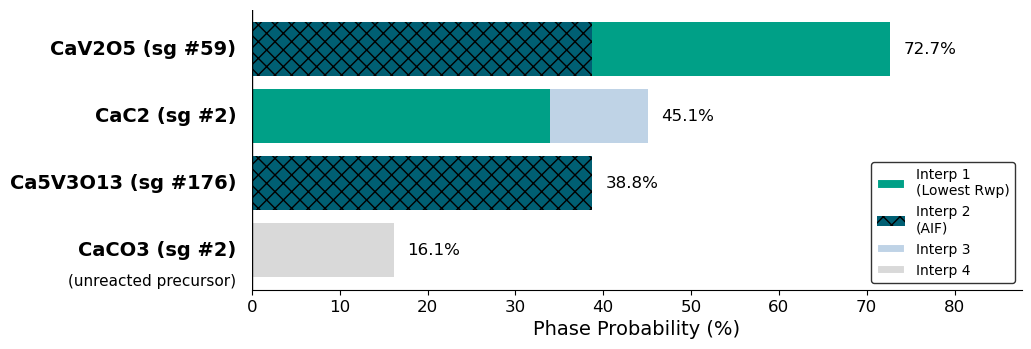

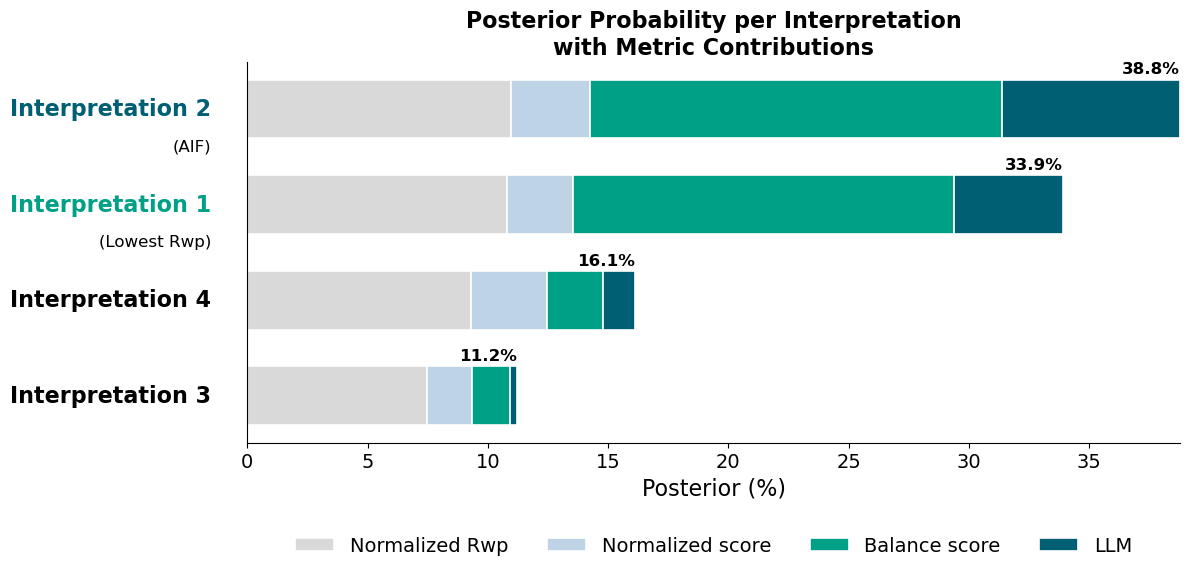

In [41]:
import matplotlib.pyplot as plt
from contextlib import contextmanager
from IPython.display import display

@contextmanager
def no_files_keep_figs():
    """Disable savefig and prevent close() so we can display figures in-notebook."""
    original_savefig = plt.savefig
    original_close = plt.close

    plt.savefig = lambda *args, **kwargs: None
    plt.close = lambda *args, **kwargs: None

    try:
        yield
    finally:
        plt.savefig = original_savefig
        plt.close = original_close


from utils import plot_phase_and_interpretation_probabilities, plot_metrics_contribution

with no_files_keep_figs():
    plot_phase_and_interpretation_probabilities(interpretations, SAMPLE_KEY, filtered_df, target)
    plot_metrics_contribution(interpretations, SAMPLE_KEY, target)

plt.show()

